<h1 id="tocheading">Table of Contents and Notebook Setup</h1>
<div id="toc"></div>

In [2]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

# MNIST

This chapter is concerned with the MNIST data set which contains 70000 imags of written images. First we used sklearn to open them. We use a function created by the author of the book to sort the data accordingly.

In [3]:
def sort_by_target(mnist):
    reorder_train = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[:60000])]))[:, 1]
    reorder_test = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[60000:])]))[:, 1]
    mnist.data[:60000] = mnist.data[reorder_train]
    mnist.target[:60000] = mnist.target[reorder_train]
    mnist.data[60000:] = mnist.data[reorder_test + 60000]
    mnist.target[60000:] = mnist.target[reorder_test + 60000]

from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, cache=True)
mnist.target = mnist.target.astype(np.int8) # fetch_openml() returns targets as strings
sort_by_target(mnist) # fetch_openml() returns an unsorted dataset

In [4]:
mnist["data"], mnist["target"]

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([0, 0, 0, ..., 9, 9, 9], dtype=int8))

Data sets loaded with Sckit-Learn have a dictionary format as follows

**DESCR** key that describes the data set <br>
**Data** key containing an array with one row per instance and one column per feature <br>
**Target** key containing an array with labels.

In [5]:
X, y = mnist["data"], mnist["target"]

In [6]:
X.shape

(70000, 784)

(70000 images with 784 pixels each)

In [7]:
y.shape

(70000,)

In this case, our data set has 70000 images with 784 features per image (28 by 28 pixels). The target array contains the labels, which in this case is the name of each symbol drawn in each picture.

Lets look at one of the images:

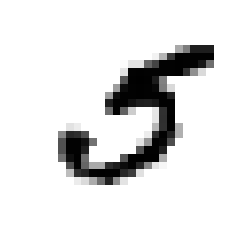

In [8]:
%matplotlib inline

some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap = matplotlib.cm.binary,
           interpolation = 'nearest')
plt.axis('off')
plt.show()

This looks like a 5, and sure enough the label tells us that it is:

In [9]:
y[36000]

5

Lets create a test set and a training set from this data set.

In [10]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

Now lets shuffle the data randomly.

In [11]:
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

# Training a Binary Classifier

For now we will look to classify one digit: the number 5. Our algorithm will thus be a binary classifier, capable of detecting either 5 or not 5.

In [12]:
y_train_5 = (y_train == 5) #boolean array
y_test_5 = (y_test == 5)

Now we need to pick a classifier and train it- a good place to start is with the *Sci-kit Gradient Descent* classifier using the class SGDClassifier. 

In [13]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=5, tol=-np.infty, random_state = 42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=5,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=-inf,
       validation_fraction=0.1, verbose=0, warm_start=False)

Lets see how it works on the number 5 we plotted above.

In [14]:
sgd_clf.predict([some_digit])

array([ True])

It returns that the number is indeed the number 5, so this is good.

# Performance Measures

Since evaluating a classifier is in many cases more difficult than evaluating a regressor (with a regressor you can just look at RMSE), we spend most of this chapter discussing this.

## Measuring Using Cross-Validation

Here we use three folds on the training data set to test the algorithm.

In [15]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.96065, 0.96115, 0.95705])

Naively we might assume that this means that the algorithm is $~95\%$ accurate. But consider this classifier below which automatically assumes that *everything* is not a five.

In [16]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool) # returns array of Falses

In [17]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.90775, 0.9105 , 0.9107 ])

Even though everything is being predicted as false, we're still getting around $90\%$ accuracy (this is because 5's account for about $10\%$ of the digits so we expect to be wrong approximately this often).

## Measuring using a Confusion Matrix

In a confusion matrix $\bf{M}$ the entry $M_{ij}$ tells you the number of times class $i$ was identified as class $j$. Under perfect classification the confusion matrix should be a diagonal (class $i$ is only identified as class $i$).

To compute the matrix, we need to have a set of predictions (similar to cross-validation). For this we will use the cross_val_predict() function

In [18]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

This is similar to cross_val_score(), but this time it returns an actual data set of predictions. Each data element is computed using a different fold.

In [19]:
y_train_pred

array([False, False, False, ..., False, False, False])

Now lets get the confusion matrix.

In [20]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53168,  1411],
       [ 1012,  4409]], dtype=int64)

The first row represents "non-five" images and the second row presents "five" images. The columns are the same, but they contain the number of classifications.

For example, looking at the entry $M_{12}$ we get that 1671 "non-five images" were classified as "five images." In general, then.


<h1><center>$M_{ij}$ "class i's" are identified as "class j's"</center></h1>


Here's a perfect matrix.

In [21]:
confusion_matrix(y_train_pred, y_train_pred)

array([[54180,     0],
       [    0,  5820]], dtype=int64)

While the confusion matrix gives a lot of information, sometimes one requires a more precise metric. The first one we consider is the accuracy of positive predictions (in this case "five images" is the *positive* class whereas "non-five-images" is the *negative* class).

$$\text{precision} = \frac{\text{TP}}{\text{TP}+\text{FP}} $$

where TP is the number of true positives (correctly identified "fives") and FP is the number of false positives (things identified as "fives" that should have been "non-fives").

This can also be combined with another metric

$$\text{recall} = \frac{\text{TP}}{\text{TP}+\text{FN}} $$

where FN is the number of false negatives (things identified as "non-fives" that should have been "fives"). To think about this in a practical way:

**Precision:** The ratio of correct positives to all things identified as positive. <br>
**Recall:** The ratio of correct positives to all things that should have been identified as positive.

In the case of detecting illness, it is better to have a higher recall than precision, since we want to treat all people who might have the illness. The low precision means that some patients might need to come in to get reaccessed.

We can also combine precision and recall into a signle metric, the F score. The F score is the harmonic mean of precision and recall, and thus is only high if *both* the precision and recall are high

$$F_1 = \frac{2}{\frac{1}{\text{precision}}+\frac{1}{\text{recall}}}=2 \cdot \frac{\text{precision} \cdot \text{recall}}{\text{precision} + \text{recall}} = \frac{\text{TP}}{\text{TP}+\frac{\text{FN}+\text{FP}}{2}}$$

In [22]:
from sklearn.metrics import precision_score, recall_score, f1_score

In [23]:
precision_score(y_train_5, y_train_pred)

0.7575601374570446

In [24]:
recall_score(y_train_5, y_train_pred)

0.813318575908504

In [25]:
f1_score(y_train_5, y_train_pred)

0.7844497820478604

## The Precision/Recall Tradeoff

The SGDClassifier makes its classification decisions by computing a threshhold based on a decision function, and if an instances score is greater than that threshhold then it is placed in the positive class, else the negative class. Thus *increasing* the threshhold increases precision but decreases recall, and *decreasing* the threshhold increases recall but decreases precision.

This can be easily imaged using a thought experiment. If the threshhold is *really high*, then both TP and FP approach zero. But in this limit, we have only the best cases (these examples would have a very high score) and so TP would be considerably larger than FP (even though both are small) and the ratio approaches 1. If the threshhold is *really low* then TP becomes really large (we account for almost all the 5's) and FN becomes really small (very few of the 5's are missed). Once again, the ratio approaches 1.

Lets look at the threshhold of a certain picture. Below we look at the threshhold of the 5 we plotted above.

In [26]:
y_score_1 = sgd_clf.decision_function([X[36000]]) #  5
y_score_2 = sgd_clf.decision_function([X[36001]]) # A poorly drawn 5
y_score_3 = sgd_clf.decision_function([X[10001]]) # The number 1
print('Score of 5 Image {}'.format(y_score_1))
print('Score of Bad-5 Image {}'.format(y_score_2))
print('Score of 1 Image {}'.format(y_score_3))

Score of 5 Image [104970.10808756]
Score of Bad-5 Image [232826.84515314]
Score of 1 Image [-334430.5875958]


Note how the badly drawn 5 gets a negative score, but the 1 (which looks quite different from a 5) gets a very negative score.

The SGDClassifier uses a threshhold of 0 for positive, so anything above 0 will be classified as a 5. Lets use cross_val_predict again and specify that we want to return decision scores instead of predictions.

In [27]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                            method="decision_function")

Instead of returning True or False, it returns the scores themselves. Thus we can vary the threshhold and easily compute the precision and recall. This is shown in the plot below.

In [28]:
y_scores

array([-689147.52503892, -169616.18408699,  -67233.83392604, ...,
       -781620.26689016, -547537.21175058, -367453.67899669])

Use a special function to get precisions and recalls.

In [29]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, threshholds = precision_recall_curve(y_train_5, y_scores)

Plot.

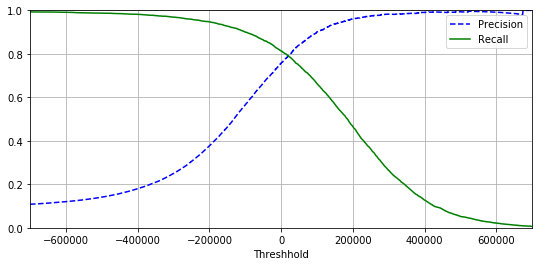

In [48]:
def plot_precision_recall_vs_threshhold(precisions, recalls, threshholds):
    plt.plot(threshholds, precisions[:-1], 'b--', label='Precision')
    plt.plot(threshholds, recalls[:-1], 'g-', label='Recall')
    plt.xlabel('Threshhold')
    plt.ylim([0, 1])
    plt.legend()
    
fig, ax = plt.subplots(figsize=(9,4))
plot_precision_recall_vs_threshhold(precisions, recalls, threshholds)
plt.xlim([-700000, 700000])
plt.grid()
plt.show()

In [38]:
precisions

array([0.09088623, 0.09087099, 0.09087251, ..., 1.        , 1.        ,
       1.        ])

As you can see, increasing precision decreases recall and vice versa. Plots like these can be used to determine an appropriate threshhold value to use for a specific task.

We can also plot precision as a function of recall:

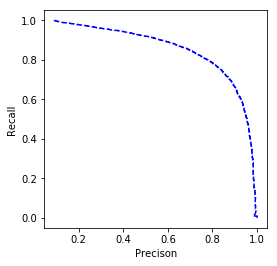

In [41]:
fig, ax = plt.subplots(figsize=(4,4))
ax.plot(precisions, recalls, 'b--', label='Precision')
ax.set_xlabel('Precison')
ax.set_ylabel('Recall')
plt.show()

Or plot the F-score

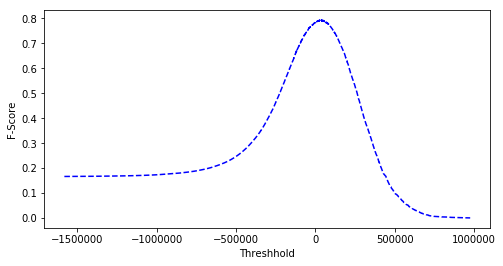

In [46]:
FScore = 2/(1/precisions[:-1]+1/recalls[:-1])

fig, ax = plt.subplots(figsize=(8,4))
ax.plot(threshholds, FScore, 'b--', label='Precision')
ax.set_xlabel('Threshhold')
ax.set_ylabel('F-Score')
plt.show()

Suppose we devide to aim for 90% precision. (For every 10 items identified as 5s, 9 of them are actually 5s). Looking at the precision recall curve, we must only take values greater than a threshhold of approximately 100000.

In [61]:
y_train_pred_90 = (y_scores > 100000) #  boolean array where True is only values above a certain threshhold
precision_score(y_train_5, y_train_pred_90)

0.9010795882500627

Note: one can increase the precision by simply making the threshhold very high. This will result in a very poor recall, however. Although we might be very strict about what we select as a 5, many 5s might get ignored. This would be not very useful with a doctor: he/she could only treat patients they are VERY sure are sick (high precision) but by doing so they ignore many patients who are sick but don't meet the strict criteria (poor recall).

## The ROC Curve

The *receiving operating characteristic* (ROC) curve is another common tool used with binary classifiers. The ROC plots the *true positive rate* vs the *false positive rate*

**True Positive Rate**: Ratio of positives to all things that should have been identified as positive (also the **recall** or also known as **sensitivity**) <br>
**False Positive Rate**: Ratio of false positives to all things that should have been identfied as negative.

$$\text{TPR} = \frac{\text{TP}}{\text{TP+FN}} \hspace{7mm}\text{FPR} = \frac{\text{FP}}{\text{TN+FP}}$$

**True Negative Rate**: Ratio of true negative to all things that should have been identified as negative. Also known as the **specificity**.

$$\text{TNR} = \frac{\text{TN}}{\text{TN+FP}}$$

Note that $\text{TNR}+\text{FPR}=1$. 

Hence the ROC curve plots sensitivity vs 1-specificity.

In [72]:
from sklearn.metrics import roc_curve
fpr, tpr, threshholds = roc_curve(y_train_5, y_scores)

A few things about the following plot: TPR and FPR both go to zero because when the threshhold is very high, very few things are identified as positive. When the threshhold is very low, almost everything is identified as positive (very few false negatives) so $\text{TPR} \to 1$. There are also many false positives ($\text{FP} >> \text{TN}$) so $\text{FPR} \to 1$.

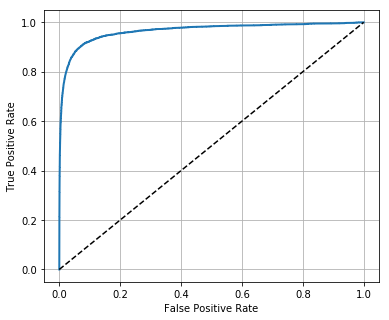

In [78]:
fig, ax = plt.subplots(figsize=(6,5))
ax.plot(fpr, tpr, linewidth=2)
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.plot([0,1],[0,1], 'k--')
ax.grid()
plt.show()

Suppose we have a completely random classifier. Consider

$$\frac{\text{TPR}}{\text{FPR}} = \frac{\text{TP}}{\text{FP}} \cdot \frac{\text{TN}+\text{FP}}{\text{TP}+\text{FN}} = \frac{\text{TP}/\text{P}}{\text{FP}/\text{N}} $$

where $P$ is all positives and $N$ is all negatives. If the classifier is totally random then $\text{TP}=\text{FN}=P/2$ and $\text{TN}=\text{FP}=N/2$ and we get

$$\frac{\text{TPR}}{\text{FPR}} = 1$$

The dotted black line in the plot above represents this random classifier. A good classifier should stay as far away from this line as possible.